In [1]:
'''
Date: 25 Aug 2020

Python version:      3.7
PyTorch version:     1.2.0

@author: Maksim Lavrov
Modified by Linnea Evanson / changed from Vanilla baseline to flexBaseline

CIFAR10 dataset

VGG16 baseline model
'''


 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# ================================================= Base VGG-16 Network ================================================================================
# ================================================= Flexible Layer ================================================================================

    
class FlexiLayer_base(nn.Module): # class FlexiLayer(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        super(FlexiLayer_base, self).__init__()
        
        self.t_1 = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding)
        self.t_2 = nn.MaxPool2d(self.kernel_size, self.stride, self.padding) # get max result with the same kernel size
        self.m = nn.Sigmoid()
        
        self.threshold1 = Variable(torch.randn((1, self.out_channels, 30, 30)))
        
        self.thresh_mean = []
        
    def forward(self, t):
        
        #self.threshold1.expand(t.size(0), self.out_channels, 30, 30)
        
        
        #cond = torch.sub(self.t_2(t), self.threshold1.cuda())
        #t_2_2 = self.m(cond*50)*self.t_2(t) # 
        #t_1_1 = self.m(cond*(-50))*self.t_1(t) # 
        #t = torch.add(t_2_2, t_1_1)
        
        return self.t_1(t) #t

    # ================================================= VGG-16 Network ================================================================================
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16,self).__init__()

        self.block1 = nn.Sequential(
                      nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      FlexiLayer_base(in_channels = 64,out_channels = 64,kernel_size = 3, padding =0),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      #nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.3))

        self.block2 = nn.Sequential(
                      nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 128,out_channels = 128,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.4))

        self.block3 = nn.Sequential(
                      nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.4))

        self.block4 = nn.Sequential(
                      nn.Conv2d(in_channels = 256,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2) ,
                      nn.Dropout2d(0.4))

        self.block5 = nn.Sequential(
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.5) )

        self.fc =     nn.Sequential(
                      nn.Linear(512,100),
                      nn.Dropout(0.5),
                      nn.BatchNorm1d(100),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(100,10), )

    def forward(self,x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = out.view(out.size(0),-1)
        out = self.fc(out)

        return out



In [2]:


from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

#from models.VGG16 import *

epsilons = [0, .05, .1, .15, .2, .25, .3]

# ======================================== prepare the dataset ==========================================================================================
mean_cifar10 = [0.485, 0.456, 0.406]   
std_cifar10 = [0.229, 0.224, 0.225]
batch_size = 100

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])


trainset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=True, download= True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


In [3]:
from __future__ import print_function

import json
import os
import sys

import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from PyHessian.utils import *
from PyHessian.density_plot import get_esd_plot
from PyHessian.density_plot import density_generate

from PyHessian.models.resnet import resnet
from PyHessian.pyhessian import hessian



def get_eigenvalues(model, trainloader, testloader):

    #*
    # @file Different utility functions
    # Copyright (c) Zhewei Yao, Amir Gholami
    # All rights reserved.
    # This file is part of PyHessian library.
    #
    # PyHessian is free software: you can redistribute it and/or modify
    # it under the terms of the GNU General Public License as published by
    # the Free Software Foundation, either version 3 of the License, or
    # (at your option) any later version.
    #
    # PyHessian is distributed in the hope that it will be useful,
    # but WITHOUT ANY WARRANTY; without even the implied warranty of
    # MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    # GNU General Public License for more details.
    #
    # You should have received a copy of the GNU General Public License
    # along with PyHessian.  If not, see <http://www.gnu.org/licenses/>.
    #*

    # Settings
    parser = argparse.ArgumentParser(description='PyTorch Example')
    parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
    parser.add_argument(
        '--mini-hessian-batch-size',
        type=int,
        default=200,
        help='input batch size for mini-hessian batch (default: 200)')
    parser.add_argument('--hessian-batch-size',
                        type=int,
                        default=200,
                        help='input batch size for hessian (default: 200)')
    parser.add_argument('--seed',
                        type=int,
                        default=1,
                        help='random seed (default: 1)')
    parser.add_argument('--batch-norm',
                        action='store_false',
                        help='do we need batch norm or not')
    parser.add_argument('--residual',
                        action='store_false',
                        help='do we need residual connect or not')

    parser.add_argument('--cuda',
                        action='store_false',
                        help='do we use gpu or not')
    parser.add_argument('--resume',
                        type=str,
                        default='fmnist_flex_model_14_52.pth',
                        help='get the checkpoint')

    args = parser.parse_args(args=[])
    # set random seed to reproduce the work
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

    for arg in vars(args):
        print(arg, getattr(args, arg))

    # get dataset
    #train_loader, test_loader = getData(name='cifar10_without_dataaugmentation',
    #                                    train_bs=args.mini_hessian_batch_size,
    #                                    test_bs=1)

    train_loader, test_loader = testloader, trainloader

    ##############
    # Get the hessian data
    ##############
    assert (args.hessian_batch_size % args.mini_hessian_batch_size == 0)
    assert (50000 % args.hessian_batch_size == 0)
    batch_num = args.hessian_batch_size // args.mini_hessian_batch_size

    if batch_num == 1:
        for inputs, labels in train_loader:
            hessian_dataloader = (inputs, labels)
            break
    else:
        hessian_dataloader = []
        for i, (inputs, labels) in enumerate(train_loader):
            hessian_dataloader.append((inputs, labels))
            if i == batch_num - 1:
                break

    if args.cuda:
        model = model.cuda()
    model = torch.nn.DataParallel(model)

    criterion = nn.CrossEntropyLoss()  # label loss

    ###################
    # Get model checkpoint, get saving folder
    ###################
    if args.resume == '':
        raise Exception("please choose the trained model")
    #model.load_state_dict(torch.load(args.resume))
    #state = torch.load('fmnist_base_model_14_28.pth')
    #model.load_state_dict(state['model'])

    ######################################################
    # Begin the computation
    ######################################################

    # turn model to eval mode
    model.eval()
    if batch_num == 1:
        hessian_comp = hessian(model,
                               criterion,
                               data=hessian_dataloader,
                               cuda=args.cuda)
    else:
        hessian_comp = hessian(model,
                               criterion,
                               dataloader=hessian_dataloader,
                               cuda=args.cuda)

    print(
        '********** finish data londing and begin Hessian computation **********')
    # @Linnea: adding print test
    #print_test = hessian_comp.dataloader_hv_product(hessian_comp, None)
    trace = hessian_comp.trace()

    #top_eigenvalues, _ = hessian_comp.eigenvalues(top_n = 100)   #get top 100 eigenvalues
    #density_eigen, density_weight = hessian_comp.density(iter = 100) #get top 150 eigenvalues in faster way than line above


    return trace

In [4]:
def get_alpha(plot_height, eign_grids):

    total_values = np.sum(plot_height)

    neg_values = []
    i = 0
    for value in eign_grids:
        if value < 0:
            neg_values.append(plot_height[i])
        i += 1

    alpha  = np.sum(neg_values) /total_values

    return alpha

In [5]:
##====================Main========================
import pickle
import os

#To_DO load pth files one by one in file /models2

all_trace = []
count = 0

base_models = os.listdir("../Imperial_Flexible_CNNs/models2")

for file in base_models:
    if (True): #calc only every 10 epochs (should take roughly 4.5 hours)
        print("CUDA Available: ",torch.cuda.is_available())
        use_cuda=True
        device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

        # Initialize the network
        model = VGG16().to(device)

        # Load the pretrained model
        state = torch.load('../Imperial_Flexible_CNNs/models2/'+file)
        model.load_state_dict(state['model'])

        # Set the model in evaluation mode. In this case this is for the Dropout layers
        model.eval()

        trace = get_eigenvalues(model, trainloader, testloader)
        
        all_trace.append(trace)
       
    
    print(100*count/152, "% complete")
    count += 1
    


    

CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
0.0 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
0.6578947368421053 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
1.3157894736842106 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation ****

********** finish data londing and begin Hessian computation **********
20.394736842105264 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
21.05263157894737 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
21.710526315789473 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
22.36842105263158 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual 

fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
41.44736842105263 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
42.10526315789474 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
42.76315789473684 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
43.

********** finish data londing and begin Hessian computation **********
61.8421052631579 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
62.5 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
63.1578947368421 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
63.81578947368421 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
re

fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
82.89473684210526 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
83.55263157894737 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
84.21052631578948 % complete
CUDA Available:  True
fff 1
mini_hessian_batch_size 200
hessian_batch_size 200
seed 1
batch_norm True
residual True
cuda True
resume fmnist_flex_model_14_52.pth
********** finish data londing and begin Hessian computation **********
84.

In [6]:
#Save all trace:
import pickle
#with open('all_trace_base.pkl', 'wb') as f:
#    pickle.dump(all_trace, f)

## Re run only after this not above when plotting

In [2]:
#BASE
import pickle
with open('all_trace_base.pkl', 'rb') as f:
    all_trace = pickle.load(f)

#Load epsilons:

with open('cifar_base_withdropout_trainerror2.pkl', 'rb') as f:
    epsilons = pickle.load(f)

#Try test accuracy rather than train error:
with open('cifar_base_withdropout_testaccuracy2.pkl', 'rb') as f:
    testepsilons = pickle.load(f)
    


In [3]:
#FLEX
import pickle
import pandas as pd
with open('all_trace_flex.pkl', 'rb') as f:
    all_trace_flex = pickle.load(f)

#Load epsilons:
with open('cifar_flex_withdropout_trainerror3.pkl', 'rb') as f:
    epsilons_flex = pickle.load(f)
    


In [4]:
# Need to order the trace values: BASE
#Load alpha_base:

import pandas as pd
import os 
import numpy as np

path = "../Imperial_Flexible_CNNs/models2"
base_models = os.listdir(path)

epoch_number = []

for file in os.listdir(path):
    if os.path.isfile(os.path.join(path, file)):
        temp = file.split("_") #calc only every 10 epochs (should take roughly 4.5 hours)
        epoch_number.append(int(temp[2]))
    

#Create database:
df_base = pd.DataFrame(list(zip(base_models,epoch_number)), columns = ['models','epoch'])
    
df_base['trace'] = all_trace

#Order dataframe by epoch number:

df_base = df_base.sort_values(by = ['epoch'])

display(df_base[0:50]) 




,models,epoch,trace
32,VGG16-BASE-nnmodule_withdropoutmodel_0_17.pth,0,"[2203.079345703125, 379.5407409667969, -1622.0..."
84,VGG16-BASE-nnmodule_withdropoutmodel_1_23.pth,1,"[2049.5185546875, 138.22015380859375, -2159.77..."
145,VGG16-BASE-nnmodule_withdropoutmodel_2_32.pth,2,"[2784.82958984375, 430.3611755371094, -2123.94..."
78,VGG16-BASE-nnmodule_withdropoutmodel_3_40.pth,3,"[3906.066650390625, 1451.2510986328125, -163.9..."
79,VGG16-BASE-nnmodule_withdropoutmodel_4_42.pth,4,"[4512.90478515625, 1748.951904296875, -234.939..."
80,VGG16-BASE-nnmodule_withdropoutmodel_5_48.pth,5,"[3473.979736328125, 2414.796875, -1518.4558105..."
14,VGG16-BASE-nnmodule_withdropoutmodel_6_50.pth,6,"[4823.16015625, 4316.8798828125, -511.01397705..."
112,VGG16-BASE-nnmodule_withdropoutmodel_7_56.pth,7,"[3281.452880859375, 3350.56689453125, 1536.396..."
146,VGG16-BASE-nnmodule_withdropoutmodel_8_61.pth,8,"[2751.576416015625, 2987.390869140625, 3556.73..."
98,VGG16-BASE-nnmodule_withdropoutmodel_9_64.pth,9,"[3134.20263671875, 3258.61572265625, 837.76147..."


In [5]:
#FLEX

# Need to order the trace values:
#Load alpha_base:

import pandas as pd
import os 
import numpy as np

path = "../Imperial_Flexible_CNNs/models3/"
base_models = os.listdir(path)

epoch_number = []

for file in os.listdir(path):
    if os.path.isfile(os.path.join(path, file)):
        temp = file.split("_") #calc only every 10 epochs (should take roughly 4.5 hours)
        epoch_number.append(int(temp[2]))
    

#Create database:
df_flex = pd.DataFrame(list(zip(base_models,epoch_number)), columns = ['models','epoch'])
    
df_flex['trace'] = all_trace_flex

#Order dataframe by epoch number:

df_flex = df_flex.sort_values(by = ['epoch'])

display(df_flex[0:50]) 


,models,epoch,trace
49,VGG16-flex-nnmodule_withdropoutmodel_0_19.pth,0,"[-1511.887451171875, 1400.49755859375]"
101,VGG16-flex-nnmodule_withdropoutmodel_1_33.pth,1,"[-314.2439880371094, 2109.259765625]"
80,VGG16-flex-nnmodule_withdropoutmodel_2_39.pth,2,"[792.803955078125, 2672.41650390625, 334.30444..."
27,VGG16-flex-nnmodule_withdropoutmodel_3_45.pth,3,"[546.7245483398438, 2767.267333984375, 476.506..."
4,VGG16-flex-nnmodule_withdropoutmodel_4_50.pth,4,"[1449.08740234375, 3242.640869140625, 20.29227..."
118,VGG16-flex-nnmodule_withdropoutmodel_5_52.pth,5,"[2211.3466796875, 5076.28857421875, 1947.69946..."
108,VGG16-flex-nnmodule_withdropoutmodel_6_55.pth,6,"[2793.5849609375, 3433.9521484375, 1544.174438..."
63,VGG16-flex-nnmodule_withdropoutmodel_7_57.pth,7,"[1985.16259765625, 4855.2783203125, -383.03228..."
120,VGG16-flex-nnmodule_withdropoutmodel_8_61.pth,8,"[3758.7197265625, 6090.39453125, 2193.36523437..."
10,VGG16-flex-nnmodule_withdropoutmodel_9_64.pth,9,"[816.56982421875, 5249.15234375, 1037.69787597..."


In [6]:
#Trace is computed up to 100 times, as 

trace_means = []

#Find the mean of the trace's across one axis:
for epoch in df_base['trace']:
    trace_means.append(np.mean(epoch))

print(len(trace_means))

print("Trace means\n", trace_means)

153
Trace means
 [-165.59441232681274, 556.005395359993, 1184.7991709391276, 1544.1352012221878, 1664.6373292922974, 1586.4754621717666, 2627.4235981532506, 2833.6364144717945, 2860.615711558949, 2916.5406901041665, 3102.4405868530275, 3618.579308646066, 3412.3161964416504, 4111.904747009277, 4558.495990621633, 5539.561678799716, 5468.258987694456, 5825.3325602213545, 6402.877432016226, 5861.618876139323, 7141.777761151714, 7025.430516560872, 8685.538423978365, 7078.2577114762935, 8207.275213068182, 9705.173193359375, 9981.9098046875, 8309.649611900593, 9818.39013671875, 9143.84598482572, 10429.375995183394, 10875.745675223214, 8555.41620342548, 10002.466477614184, 10118.369697265625, 11073.195978338068, 8959.888834635416, 12227.39000108507, 11268.58233173077, 11562.412841796875, 13571.450265066964, 12557.57569173177, 11743.718493009868, 14289.525817871094, 14793.207856830797, 13035.553350033968, 14198.609067855343, 15039.47327931722, 13603.852478027344, 16247.899482593202, 13134.64931

In [7]:
#Trace is computed up to 100 times, as 

trace_means_flex = []

#Find the mean of the trace's across one axis:
for epoch in df_flex['trace']:
    trace_means_flex.append(np.mean(epoch))

print(len(trace_means_flex))

print("Trace means\n", trace_means_flex)

153
Trace means
 [-55.6949462890625, 897.5078887939453, 1424.858623873803, 1376.7707352271448, 1529.2179022093078, 2564.716527210582, 2134.294776916504, 1929.5144100846915, 2425.4845385742187, 2647.9482500994645, 2581.51808820452, 3443.337159809313, 3448.229519435338, 4403.351220703125, 4528.368384564509, 3967.1564764883005, 3534.2600232805526, 3392.7986907958984, 4733.192775980631, 5328.547338867187, 4031.3126475183585, 4563.132162655101, 6232.9538976791055, 5053.0050193591, 6562.456310365258, 8656.823716107538, 6305.954804992676, 6866.365757533482, 7040.289753723145, 7834.274693080357, 7219.352493286133, 8900.702132161457, 8567.94736550071, 8600.038651148478, 7233.856004503038, 9312.179080447635, 9688.070353190104, 7079.005662966997, 8742.614799499512, 7636.378497314453, 9258.013240749553, 7586.730004882813, 9663.234506460336, 12720.340194702148, 6664.294158935547, 11437.381225585938, 12655.120218528891, 10532.852645874023, 11364.490293921494, 9512.908569335938, 12636.89711216518, 16

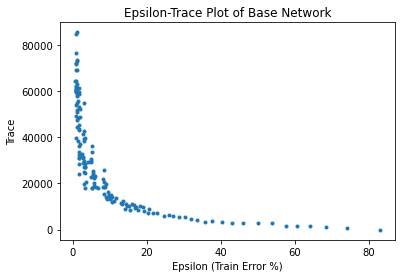

In [8]:
#Plot alpha - epsilon
import matplotlib.pyplot as plt
plt.figure()
plt.plot(epsilons,trace_means, '.')
plt.title("Epsilon-Trace Plot of Base Network")
plt.xlabel("Epsilon (Train Error %)")
plt.ylabel("Trace")
plt.show()

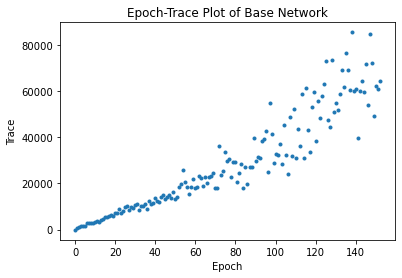

In [9]:
#Plot trace against epoch
epochs = [x for x in range(153)]
plt.plot(epochs,trace_means, '.')
plt.title("Epoch-Trace Plot of Base Network")
plt.xlabel("Epoch")
plt.ylabel("Trace")
plt.show()

## Plot base and flex full networks 

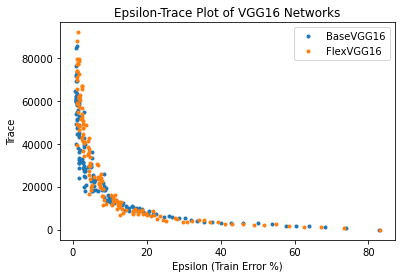

In [10]:
#Plot alpha - epsilon
import matplotlib.pyplot as plt
plt.figure()
plt.plot(epsilons,trace_means, '.', label = "BaseVGG16")
plt.plot(epsilons_flex, trace_means_flex, '.', label = "FlexVGG16")
plt.title("Epsilon-Trace Plot of VGG16 Networks")
plt.xlabel("Epsilon (Train Error %)")
plt.ylabel("Trace")
plt.legend()
plt.show()

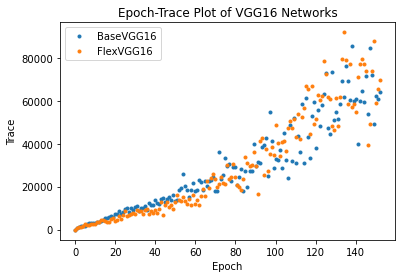

In [11]:
#Plot trace against epoch
plt.plot(epochs,trace_means, '.', label = "BaseVGG16")
plt.plot(epochs,trace_means_flex, '.', label = "FlexVGG16")
plt.title("Epoch-Trace Plot of VGG16 Networks")
plt.xlabel("Epoch")
plt.ylabel("Trace")
plt.legend()
plt.show()